# MOSE 3×5 Optimization

This notebook optimizes a three-variable MOSE design against five stakeholder objectives.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import pchip_interpolate

from genetic_algorithm_pfm.genetic_algorithm_pfm.algorithm import GeneticAlgorithm

In [2]:
# Stakeholder configuration (edit weights to match stakeholder input)
TOTAL_LENGTH = 1600.0

OBJECTIVE_KEYS = ['initial_cost', 'maintenance_cost', 'sight', 'accessibility', 'water_quality']

STAKEHOLDER_DATA = [
    {
        'name': 'Municipality',
        'weight': 0.4,
        'objective_weights': {
            'initial_cost': 0.45,
            'maintenance_cost': 0.30,
            'sight': 0.05,
            'accessibility': 0.10,
            'water_quality': 0.10,
        },
    },
    {
        'name': 'Residents',
        'weight': 0.35,
        'objective_weights': {
            'initial_cost': 0.10,
            'maintenance_cost': 0.15,
            'sight': 0.40,
            'accessibility': 0.25,
            'water_quality': 0.10,
        },
    },
    {
        'name': 'Environmental agency',
        'weight': 0.25,
        'objective_weights': {
            'initial_cost': 0.10,
            'maintenance_cost': 0.15,
            'sight': 0.10,
            'accessibility': 0.15,
            'water_quality': 0.50,
        },
    },
    {
        'name': 'Shipping companies',
        'weight': 0.15,
        'objective_weights': {
            'initial_cost': 0.15,
            'maintenance_cost': 0.15,
            'sight': 0.05,
            'accessibility': 0.45,
            'water_quality': 0.20,
        },
    },
]

def _normalize(values):
    values = np.asarray(values, dtype=float)
    total = values.sum()
    if total <= 0:
        raise ValueError('Weights must sum to a positive value.')
    return values / total

STAKEHOLDER_NAMES = [item['name'] for item in STAKEHOLDER_DATA]
STAKEHOLDER_WEIGHTS = _normalize([item['weight'] for item in STAKEHOLDER_DATA])
STAKEHOLDER_OBJECTIVE_WEIGHTS = np.vstack([
    _normalize([item['objective_weights'].get(key, 0.0) for key in OBJECTIVE_KEYS])
    for item in STAKEHOLDER_DATA
])

ACTIVE_STAKEHOLDER_WEIGHTS = STAKEHOLDER_WEIGHTS.copy()

def set_active_stakeholder_weights(weight_vector):
    global ACTIVE_STAKEHOLDER_WEIGHTS
    weights = np.asarray(weight_vector, dtype=float)
    total = weights.sum()
    if total <= 0:
        raise ValueError('Stakeholder weights must sum to a positive value.')
    ACTIVE_STAKEHOLDER_WEIGHTS = weights / total


# Preference knot points (edit to match stakeholder data)
initial_cost_knots = [5.0e8, 6.0e9, 8.0e9]
initial_cost_pref = [100, 50, 0]

maintenance_cost_knots = [1.0e10, 10.0e11, 1.5e12]
maintenance_cost_pref = [100, 40, 0]

sight_knots = [0, 5, 10]
sight_pref = [0, 50, 100]

access_knots = [0, 5, 10]
access_pref = [0, 50, 100]

water_knots = [0, 5, 10]
water_pref = [0, 50, 100]

# Design variable bounds: x1 (m), x2 (-), x3 (-) — adjust if needed
bounds = [
    [0.0, TOTAL_LENGTH],  # x1
    [1.0, 10.0],          # x2
    [0.5, 5.0],           # x3
]

# Optional constraints placeholder: add callables if domain limits are required
constraints = []


In [3]:
MIN_CLOSING_TIME = 1e-3


def compute_initial_cost(x1, x2, x3):
    x1 = np.asarray(x1, dtype=float)
    x2 = np.asarray(x2, dtype=float)
    x3 = np.asarray(x3, dtype=float)

    movable_cost_per_meter = (
        5.2e5
        + 4.8e4 * np.power(x2, 1.5)
        + 2.2e5 / np.maximum(x3, MIN_CLOSING_TIME)
    )
    permanent_cost_per_meter = (
        1.8e4
        + 5.5e3 * np.power(x2, 1.1)
    )
    return x1 * movable_cost_per_meter + (TOTAL_LENGTH - x1) * permanent_cost_per_meter


def compute_maintenance_cost(x1, x2, x3):
    x1 = np.asarray(x1, dtype=float)
    x2 = np.asarray(x2, dtype=float)
    x3 = np.asarray(x3, dtype=float)

    movable_per_meter = (
        1.25e6
        + 4.8e5 * x2
        + 1.5e6 / np.power(np.maximum(x3, MIN_CLOSING_TIME), 1.2)
    )
    fixed_per_meter = (
        8.5e4
        + 2.2e4 * x2
    )

    movable_cost = movable_per_meter * x1 * 180.0
    fixed_cost = fixed_per_meter * (TOTAL_LENGTH - x1) * 55.0
    return movable_cost + fixed_cost


def compute_sight(x1, x2, x3):
    x1 = np.asarray(x1, dtype=float)
    x2 = np.asarray(x2, dtype=float)

    movable_view = (x1 / TOTAL_LENGTH) * 10.0
    fixed_view = ((TOTAL_LENGTH - x1) / TOTAL_LENGTH) * 10.0 / np.maximum(x2, 1e-6)
    raw = movable_view + fixed_view
    return np.clip(raw, sight_knots[0], sight_knots[-1])


def compute_accessibility(x1, x2, x3):
    x1 = np.asarray(x1, dtype=float)
    x3 = np.asarray(x3, dtype=float)
    raw = (x1 / TOTAL_LENGTH) * 10.0 - (10.0 / 7.0) * x3
    return np.clip(raw, access_knots[0], access_knots[-1])


def compute_water_quality(x1, x2, x3):
    x1 = np.asarray(x1, dtype=float)
    x3 = np.asarray(x3, dtype=float)
    raw = (x1 / TOTAL_LENGTH) * 10.0 - (10.0 / 24.0) * x3
    return np.clip(raw, water_knots[0], water_knots[-1])


def preference_initial_cost(x1, x2, x3):
    costs = compute_initial_cost(x1, x2, x3)
    costs = np.clip(costs, initial_cost_knots[0], initial_cost_knots[-1])
    return pchip_interpolate(initial_cost_knots, initial_cost_pref, costs)


def preference_maintenance_cost(x1, x2, x3):
    costs = compute_maintenance_cost(x1, x2, x3)
    costs = np.clip(costs, maintenance_cost_knots[0], maintenance_cost_knots[-1])
    return pchip_interpolate(maintenance_cost_knots, maintenance_cost_pref, costs)


def preference_sight(x1, x2, x3):
    scores = compute_sight(x1, x2, x3)
    return pchip_interpolate(sight_knots, sight_pref, scores)


def preference_accessibility(x1, x2, x3):
    scores = compute_accessibility(x1, x2, x3)
    return pchip_interpolate(access_knots, access_pref, scores)


def preference_water_quality(x1, x2, x3):
    scores = compute_water_quality(x1, x2, x3)
    return pchip_interpolate(water_knots, water_pref, scores)


def objective(values):
    x1 = values[:, 0]
    x2 = values[:, 1]
    x3 = values[:, 2]

    preferences = {
        'initial_cost': preference_initial_cost(x1, x2, x3),
        'maintenance_cost': preference_maintenance_cost(x1, x2, x3),
        'sight': preference_sight(x1, x2, x3),
        'accessibility': preference_accessibility(x1, x2, x3),
        'water_quality': preference_water_quality(x1, x2, x3),
    }

    stacked_preferences = np.vstack([np.asarray(preferences[key], dtype=float) for key in OBJECTIVE_KEYS])
    stakeholder_scores = np.asarray(STAKEHOLDER_OBJECTIVE_WEIGHTS @ stacked_preferences, dtype=float)
    return ACTIVE_STAKEHOLDER_WEIGHTS.tolist(), stakeholder_scores.tolist()


Running GA with minmax | scenario: Current mix
The type of aggregation is set to minmax
Generation   Best score   Mean             Max stall    Diversity    Number of non-feasible results
0            6.1355       14.751           0            0.003        0           
1            5.4715       8.5748           0            0.081        0           
2            5.4529       7.1369           0            0.213        0           
3            5.4392       6.5505           0            0.292        0           
4            5.4351       6.1014           0            0.299        0           
5            5.433        5.963            0            0.302        0           
6            5.433        5.9591           0            0.301        0           
7            5.433        5.7457           1            0.311        0           
8            5.433        5.8062           2            0.311        0           
9            5.433        5.7341           3            0.311        0    

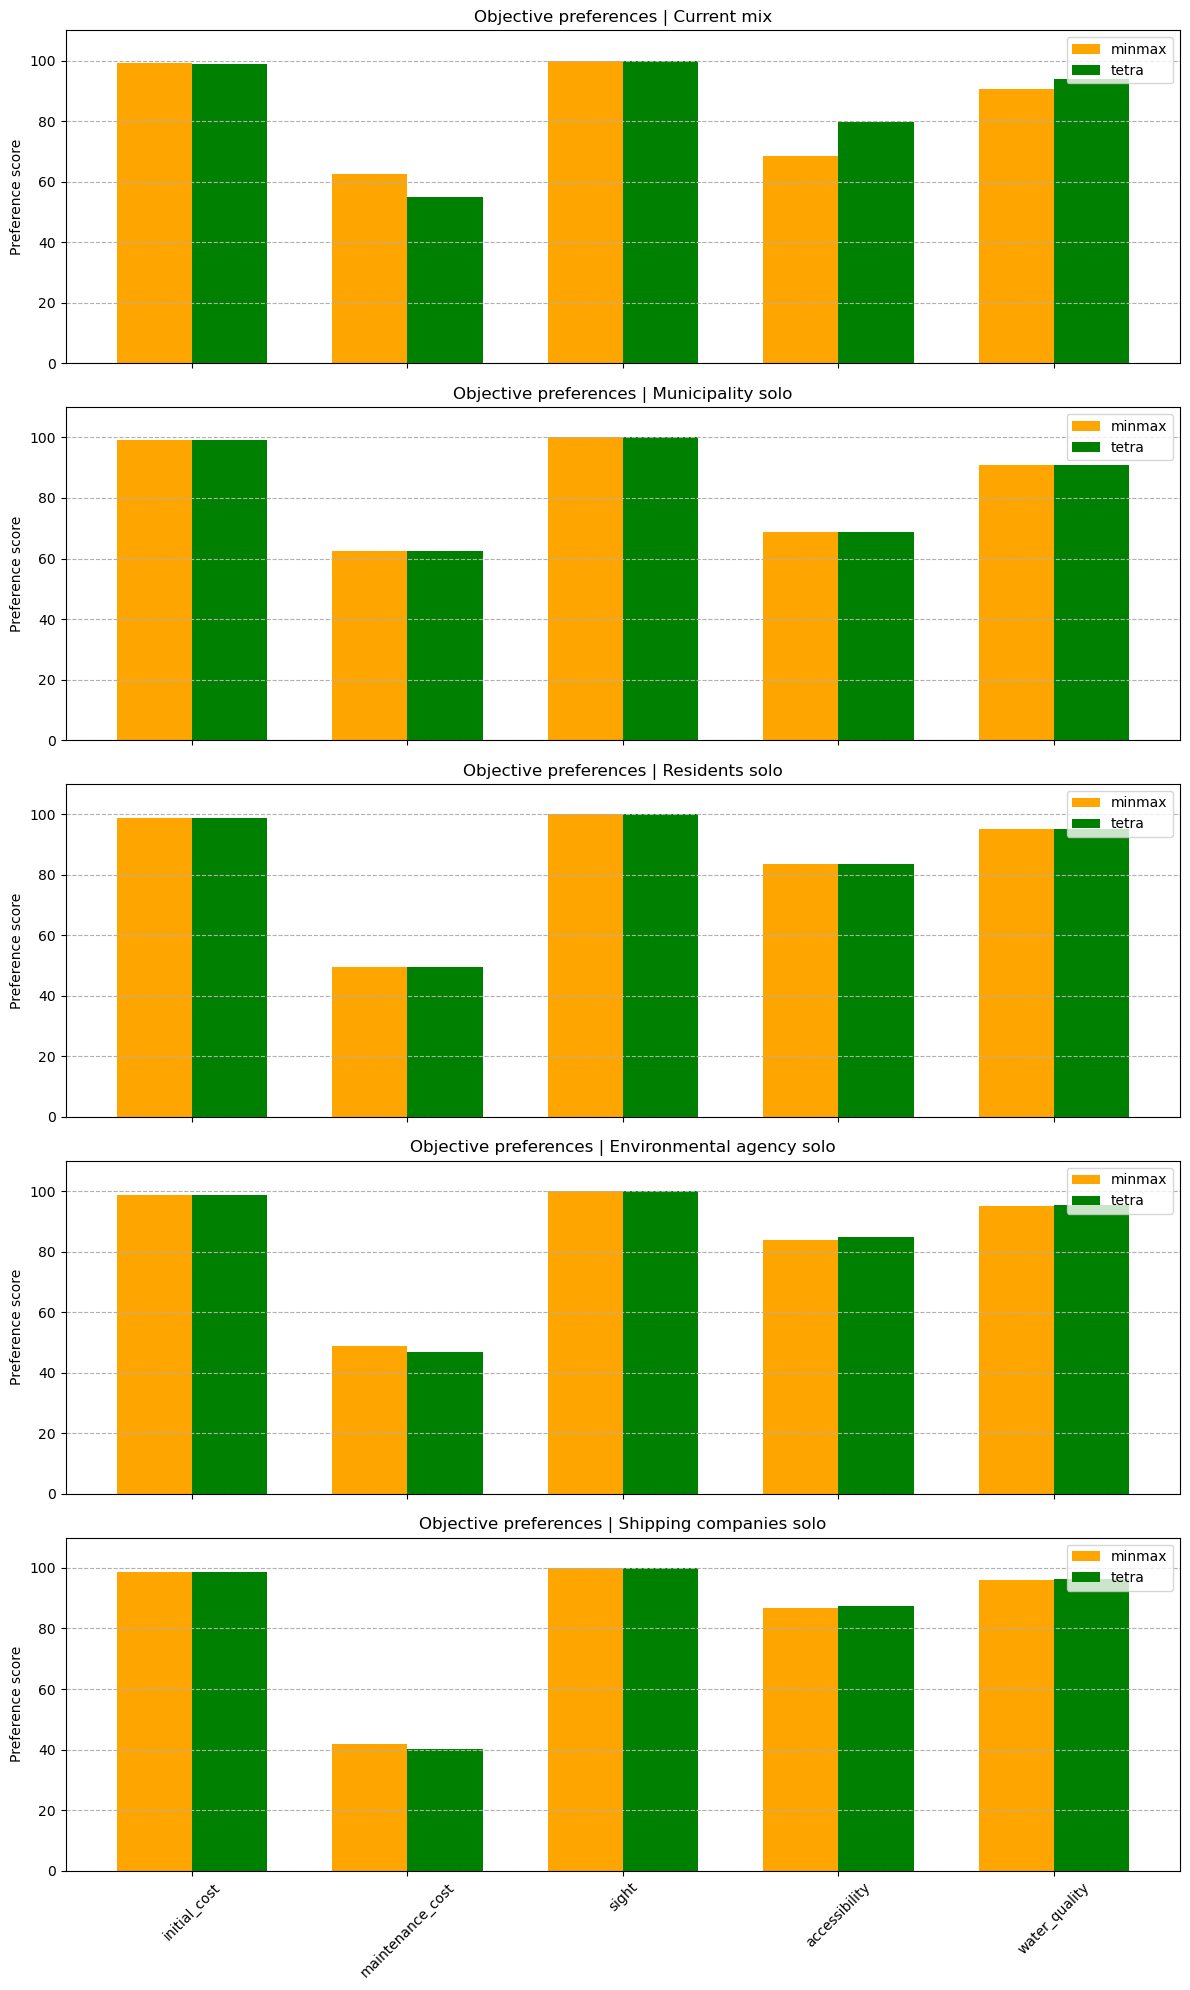

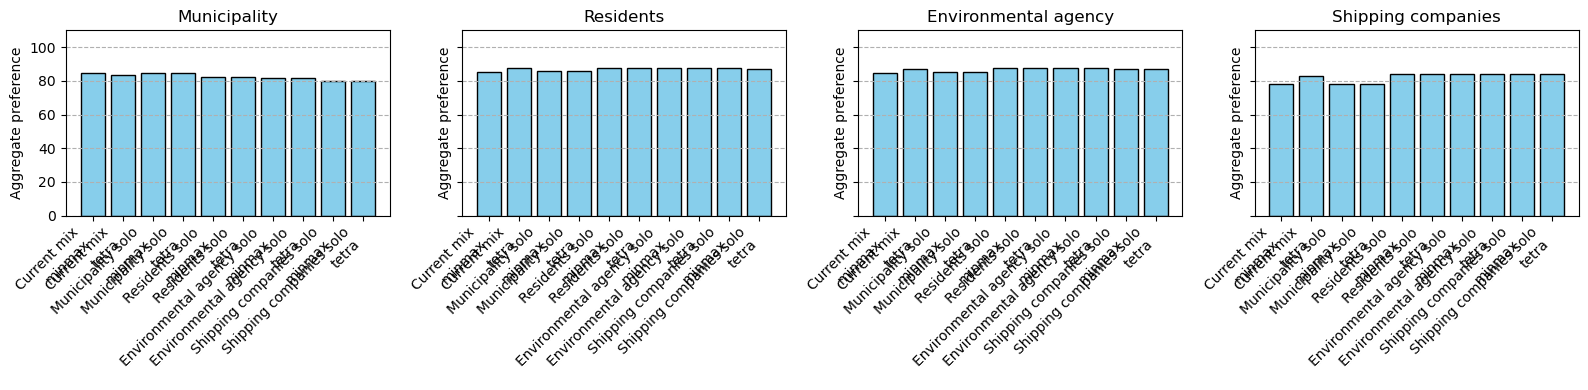

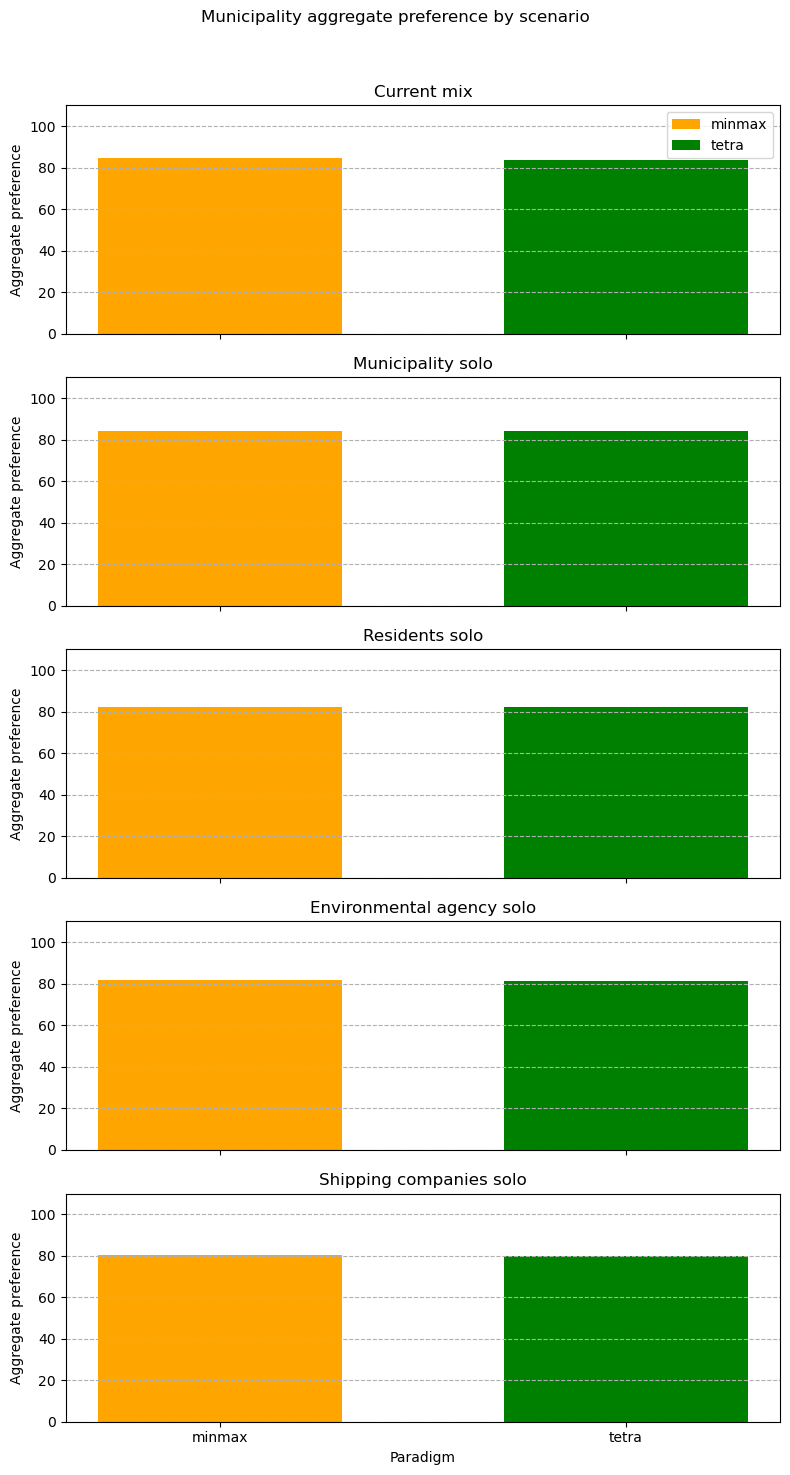

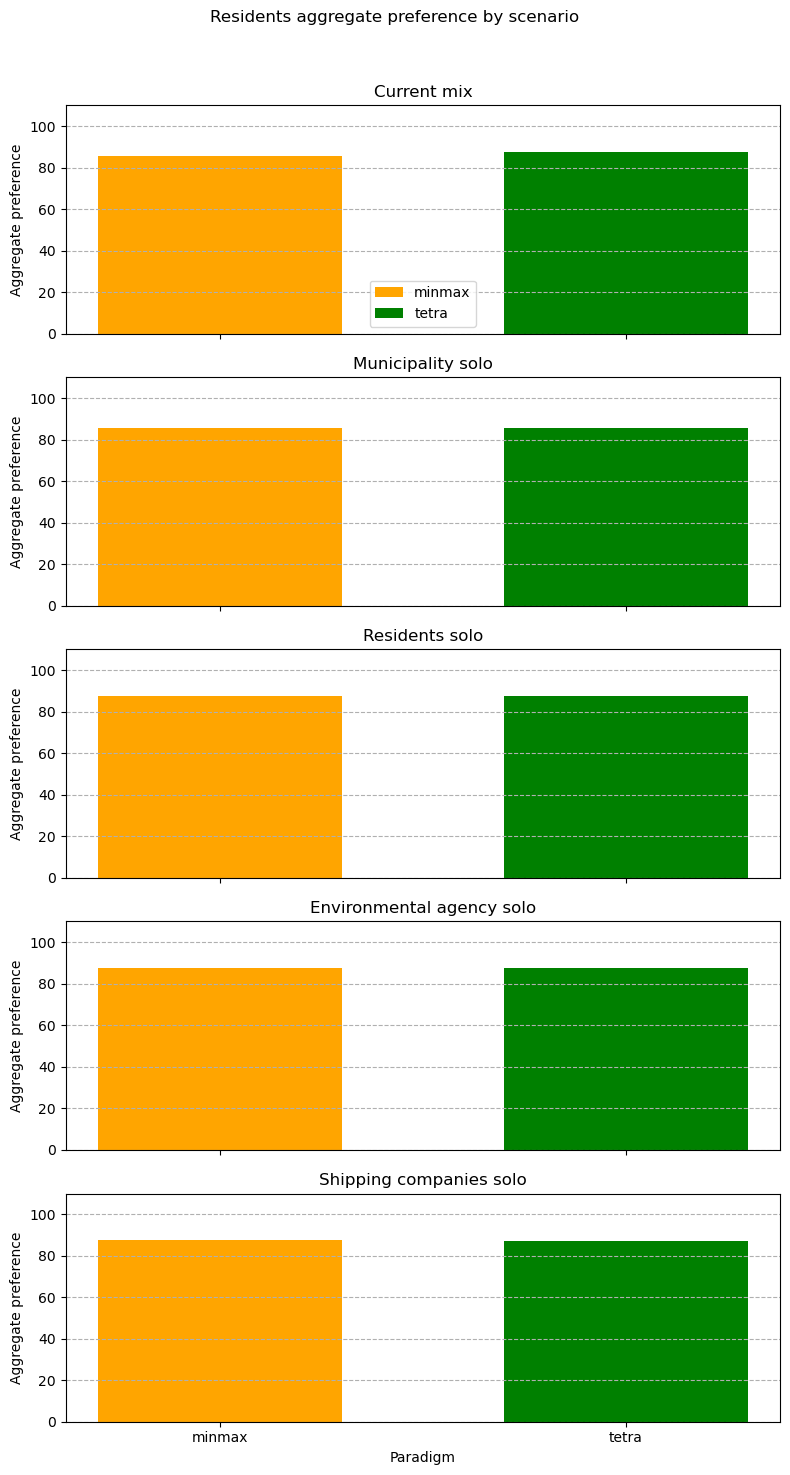

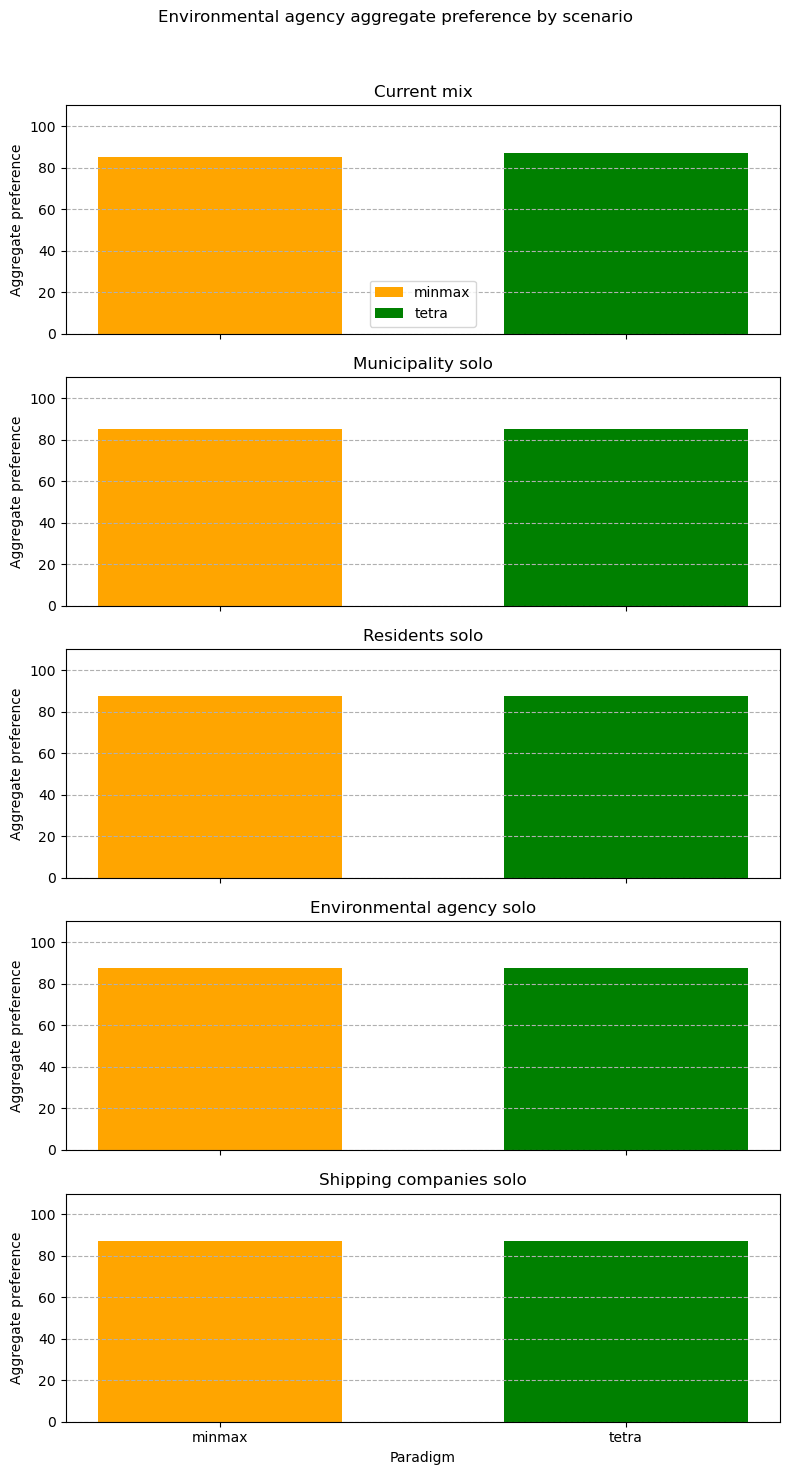

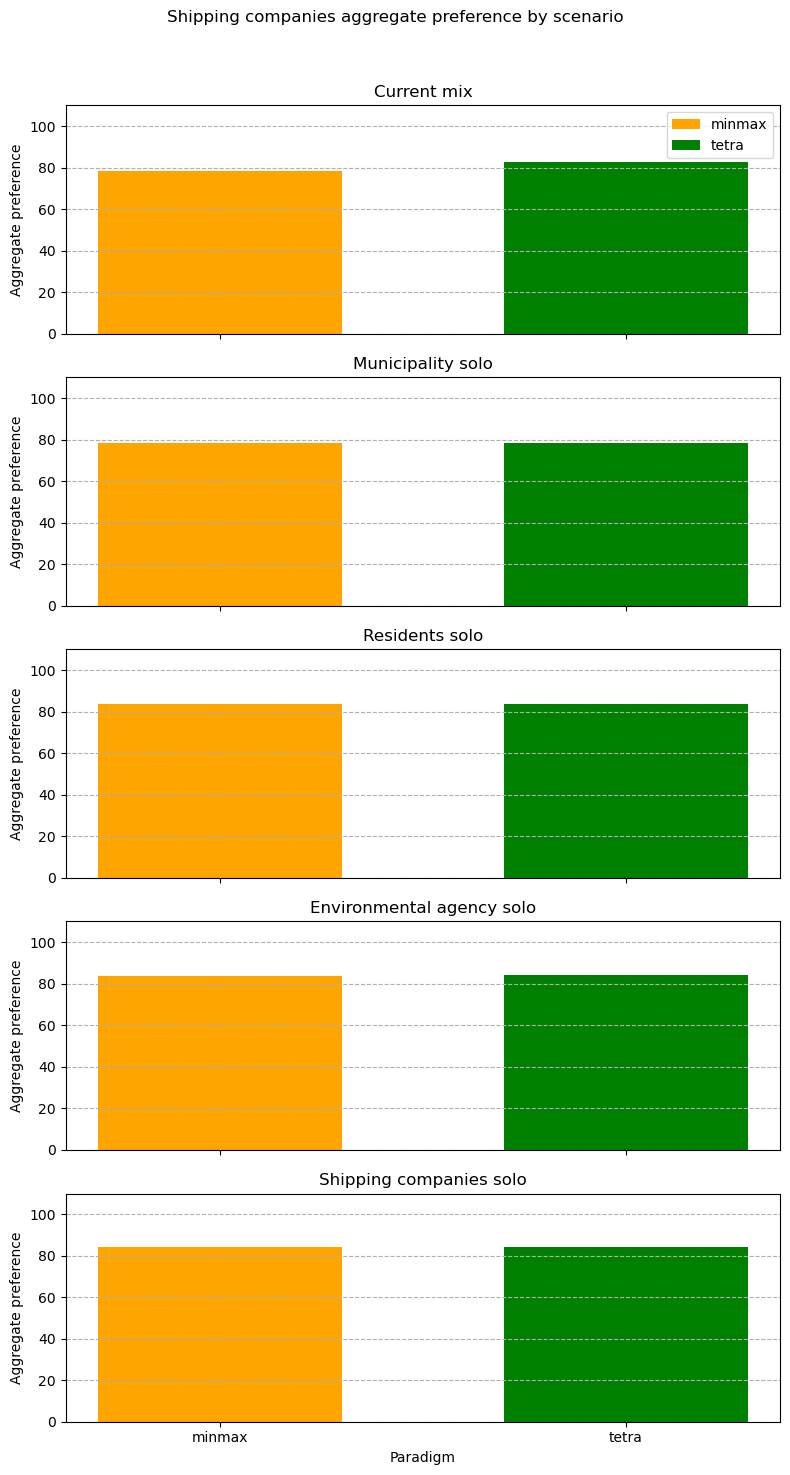

In [4]:

paradigms = ['minmax', 'tetra']
markers = ['o', '*', 's', 'd']
colours = ['orange', 'green', 'blue', 'purple', 'red', 'teal']

history = []
stakeholder_histories = []

scenarios = [{'label': 'Current mix', 'weights': STAKEHOLDER_WEIGHTS}]
for idx, name in enumerate(STAKEHOLDER_NAMES):
    one_hot = np.zeros_like(STAKEHOLDER_WEIGHTS)
    one_hot[idx] = 1.0
    scenarios.append({'label': f'{name} solo', 'weights': one_hot})

for scenario in scenarios:
    set_active_stakeholder_weights(scenario['weights'])

    for idx, paradigm in enumerate(paradigms):
        options = {
            'n_bits': 10,
            'n_iter': 500,
            'n_pop': 600,
            'r_cross': 0.8,
            'max_stall': 10,
            'aggregation': paradigm,
            'var_type': 'real'
        }

        print(f"Running GA with {paradigm} | scenario: {scenario['label']}")
        ga = GeneticAlgorithm(objective=objective, constraints=constraints, bounds=bounds, options=options)
        try:
            score, design_variables, _ = ga.run()
        except Exception as exc:
            if paradigm == 'tetra':
                print(f"Tetra run failed for scenario {scenario['label']} due to: {exc}")
                print('Skipping Tetra run for this scenario because the solver could not be reached. Proceeding with other runs.')
                continue
            raise

        x1_opt, x2_opt, x3_opt = design_variables

        metrics = {
            'initial_cost': compute_initial_cost(x1_opt, x2_opt, x3_opt),
            'maintenance_cost': compute_maintenance_cost(x1_opt, x2_opt, x3_opt),
            'sight': compute_sight(x1_opt, x2_opt, x3_opt),
            'accessibility': compute_accessibility(x1_opt, x2_opt, x3_opt),
            'water_quality': compute_water_quality(x1_opt, x2_opt, x3_opt),
        }

        preferences = {
            'initial_cost': float(preference_initial_cost(np.array([x1_opt]), np.array([x2_opt]), np.array([x3_opt]))[0]),
            'maintenance_cost': float(preference_maintenance_cost(np.array([x1_opt]), np.array([x2_opt]), np.array([x3_opt]))[0]),
            'sight': float(preference_sight(np.array([x1_opt]), np.array([x2_opt]), np.array([x3_opt]))[0]),
            'accessibility': float(preference_accessibility(np.array([x1_opt]), np.array([x2_opt]), np.array([x3_opt]))[0]),
            'water_quality': float(preference_water_quality(np.array([x1_opt]), np.array([x2_opt]), np.array([x3_opt]))[0]),
        }

        _, stakeholder_pref_arrays = objective(np.array([[x1_opt, x2_opt, x3_opt]]))
        stakeholder_preferences = {
            name: float(stakeholder_pref_arrays[i][0])
            for i, name in enumerate(STAKEHOLDER_NAMES)
        }

        scenario_stakeholder_history = []
        for s_idx, s_name in enumerate(STAKEHOLDER_NAMES):
            scenario_stakeholder_history.append({
                'scenario': scenario['label'],
                'scenario_weights': ACTIVE_STAKEHOLDER_WEIGHTS.tolist(),
                'paradigm': paradigm,
                'stakeholder': s_name,
                'preferences': preferences.copy(),
                'stakeholder_score': float(stakeholder_pref_arrays[s_idx][0]),
            })
        stakeholder_histories.extend(scenario_stakeholder_history)
        history.append({
            'scenario': scenario['label'],
            'scenario_weights': ACTIVE_STAKEHOLDER_WEIGHTS.tolist(),
            'paradigm': paradigm,
            'design': (x1_opt, x2_opt, x3_opt),
            'metrics': metrics,
            'preferences': preferences,
            'stakeholder_preferences': stakeholder_preferences,
        })

        print(f"Optimal design for {paradigm} ({scenario['label']}):")
        print(f"  x1 = {x1_opt:.2f}")
        print(f"  x2 = {x2_opt:.2f}")
        print(f"  x3 = {x3_opt:.2f}")
        print('  Metrics:')
        for key, value in metrics.items():
            print(f"    {key}: {value:.3f}")
        print('  Preference scores:')
        for key, value in preferences.items():
            print(f"    {key}: {value:.2f}")
        print('  Stakeholder aggregates:')
        for name, value in stakeholder_preferences.items():
            print(f"    {name}: {value:.2f}")
        print('-' * 60)

# Restore default stakeholder weighting after sweeps
set_active_stakeholder_weights(STAKEHOLDER_WEIGHTS)

labels = list(history[0]['preferences'].keys()) if history else []
x = np.arange(len(labels))
width = 0.35

fig, axes = plt.subplots(len(scenarios), 1, figsize=(12, 4 * len(scenarios)), sharex=True)
axes = np.atleast_1d(axes)

for ax, scenario in zip(axes, scenarios):
    subset = [record for record in history if record['scenario'] == scenario['label']]
    for i, record in enumerate(subset):
        scores = [record['preferences'][label] for label in labels]
        ax.bar(x + i * width, scores, width, label=record['paradigm'], color=colours[(i) % len(colours)])
    ax.set_title(f"Objective preferences | {scenario['label']}")
    ax.set_ylabel('Preference score')
    ax.set_ylim(0, 110)
    ax.grid(linestyle='--', axis='y')
    ax.legend()

axes[-1].set_xticks(x + width * (len(paradigms) - 1) / 2)
axes[-1].set_xticklabels(labels, rotation=45)
fig.tight_layout()
plt.show()

fig2, axes2 = plt.subplots(1, len(STAKEHOLDER_NAMES), figsize=(4 * len(STAKEHOLDER_NAMES), 4), sharey=True)
axes2 = np.atleast_1d(axes2)
run_labels = [f"{record['scenario']}\n{record['paradigm']}" for record in history]
x_runs = np.arange(len(history))

for idx, (ax, stakeholder) in enumerate(zip(axes2, STAKEHOLDER_NAMES)):
    values = [record['stakeholder_preferences'][stakeholder] for record in history]
    ax.bar(x_runs, values, color='skyblue', edgecolor='black')
    ax.set_title(stakeholder)
    ax.set_xticks(x_runs)
    ax.set_xticklabels(run_labels, rotation=45, ha='right')
    ax.set_ylabel('Aggregate preference')
    ax.set_ylim(0, 110)
    ax.grid(linestyle='--', axis='y')

fig2.tight_layout()
plt.show()

if stakeholder_histories:
    for stakeholder in STAKEHOLDER_NAMES:
        subset = [record for record in stakeholder_histories if record['stakeholder'] == stakeholder]
        if not subset:
            continue
        fig_stakeholder, axes_stakeholder = plt.subplots(len(scenarios), 1, figsize=(8, 3 * len(scenarios)), sharex=True)
        axes_stakeholder = np.atleast_1d(axes_stakeholder)
        for axis_idx, (ax, scenario) in enumerate(zip(axes_stakeholder, scenarios)):
            has_data = False
            for paradigm_idx, paradigm in enumerate(paradigms):
                match = next((rec for rec in subset if rec['scenario'] == scenario['label'] and rec['paradigm'] == paradigm), None)
                if match is None:
                    continue
                has_data = True
                label = paradigm if axis_idx == 0 else None
                ax.bar(paradigm_idx, match['stakeholder_score'], width=0.6, color=colours[paradigm_idx % len(colours)], label=label)
            if not has_data:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(scenario['label'])
            ax.set_ylabel('Aggregate preference')
            ax.set_xticks(range(len(paradigms)))
            ax.set_xticklabels(paradigms)
            ax.set_ylim(0, 110)
            ax.grid(linestyle='--', axis='y')
        axes_stakeholder[-1].set_xlabel('Paradigm')
        if axes_stakeholder.size > 0:
            axes_stakeholder[0].legend()
        fig_stakeholder.suptitle(f"{stakeholder} aggregate preference by scenario")
        fig_stakeholder.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


In [5]:
# Summary of optimal design variables and key metrics
if not history:
    raise RuntimeError('Run the GA cell first to populate history.')

print('Scenario               | Paradigm | x1 [m] | x2 [-] | x3 [-] | Initial cost | Maintenance cost | Sight | Accessibility | Water quality')
print('-' * 150)
for record in history:
    x1_opt, x2_opt, x3_opt = record['design']
    metrics = record['metrics']
    print(f"{record['scenario']:<22} | {record['paradigm']:>8} | {x1_opt:7.2f} | {x2_opt:6.2f} | {x3_opt:6.2f} | "
          f"{metrics['initial_cost']:12.3e} | {metrics['maintenance_cost']:14.3e} | "
          f"{metrics['sight']:5.2f} | {metrics['accessibility']:12.2f} | {metrics['water_quality']:13.2f}")

print() 
print('Scenario-specific stakeholder weightings:')
seen = set()
for record in history:
    key = record['scenario']
    if key in seen:
        continue
    seen.add(key)
    weights_str = ', '.join(
        f"{name}: {weight:.3f}"
        for name, weight in zip(STAKEHOLDER_NAMES, record['scenario_weights'])
    )
    print(f"  {record['scenario']:<22} -> {weights_str}")

print()
print('Stakeholder aggregate preference scores:')
row_header = 'Scenario'.ljust(22) + '| Paradigm '.ljust(12)
for name in STAKEHOLDER_NAMES:
    row_header += f"| {name:>18} "
print(row_header)
print('-' * len(row_header))
for record in history:
    row = f"{record['scenario']:<22}| {record['paradigm']:>8} "
    for name in STAKEHOLDER_NAMES:
        row += f"| {record['stakeholder_preferences'][name]:18.2f} "
    print(row)



Scenario               | Paradigm | x1 [m] | x2 [-] | x3 [-] | Initial cost | Maintenance cost | Sight | Accessibility | Water quality
------------------------------------------------------------------------------------------------------------------------------------------------------
Current mix            |   minmax | 1598.44 |   1.00 |   2.21 |    1.067e+09 |      6.645e+11 | 10.00 |         6.83 |          9.07
Current mix            |    tetra | 1598.44 |   1.00 |   1.42 |    1.155e+09 |      7.804e+11 | 10.00 |         7.96 |          9.40
Municipality solo      |   minmax | 1598.44 |   1.00 |   2.18 |    1.069e+09 |      6.669e+11 | 10.00 |         6.87 |          9.08
Municipality solo      |    tetra | 1598.44 |   1.00 |   2.18 |    1.069e+09 |      6.669e+11 | 10.00 |         6.87 |          9.08
Residents solo         |   minmax | 1598.44 |   1.00 |   1.15 |    1.214e+09 |      8.626e+11 | 10.00 |         8.35 |          9.51
Residents solo         |    tetra | 1598.44 |   1

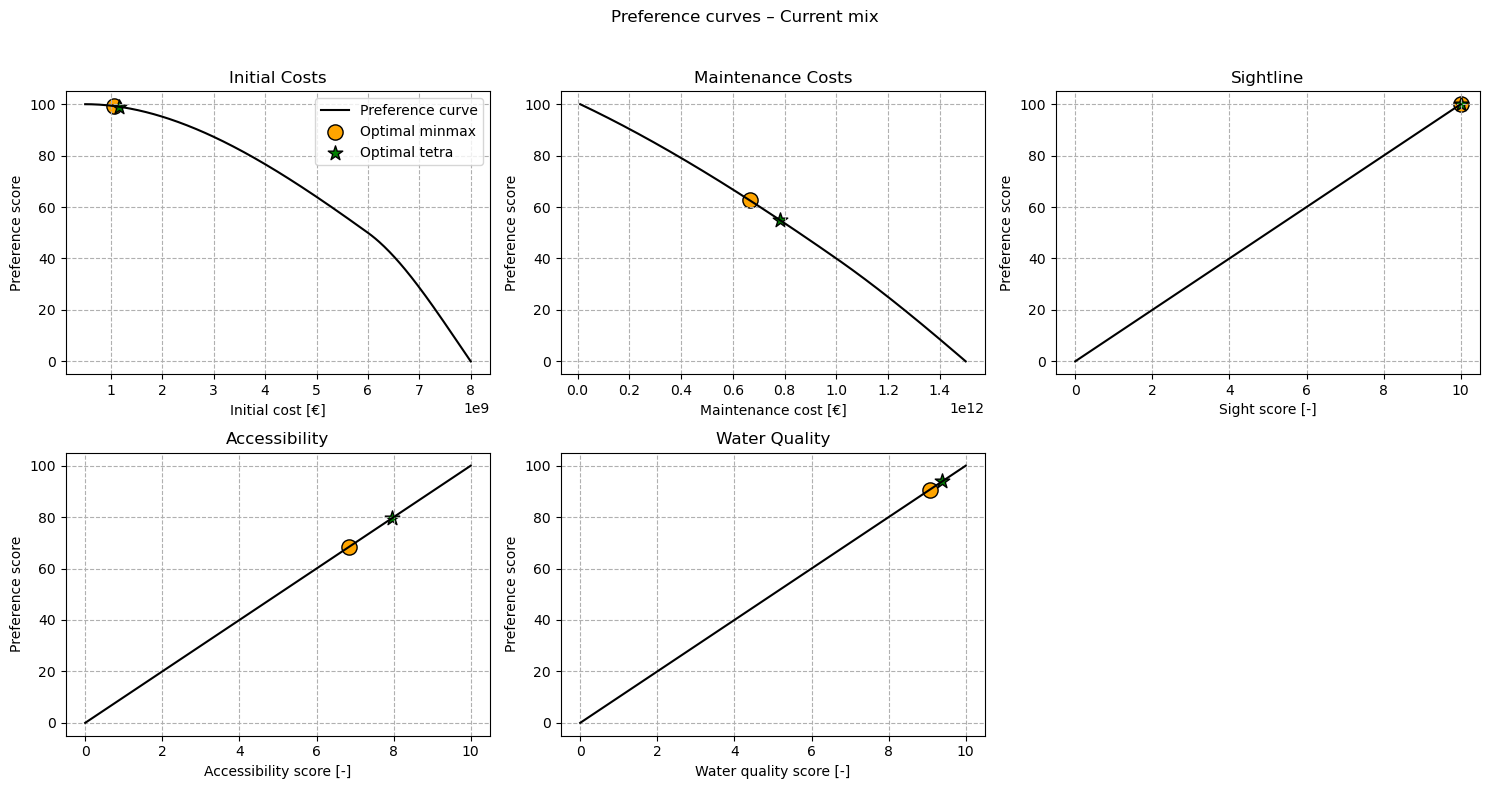

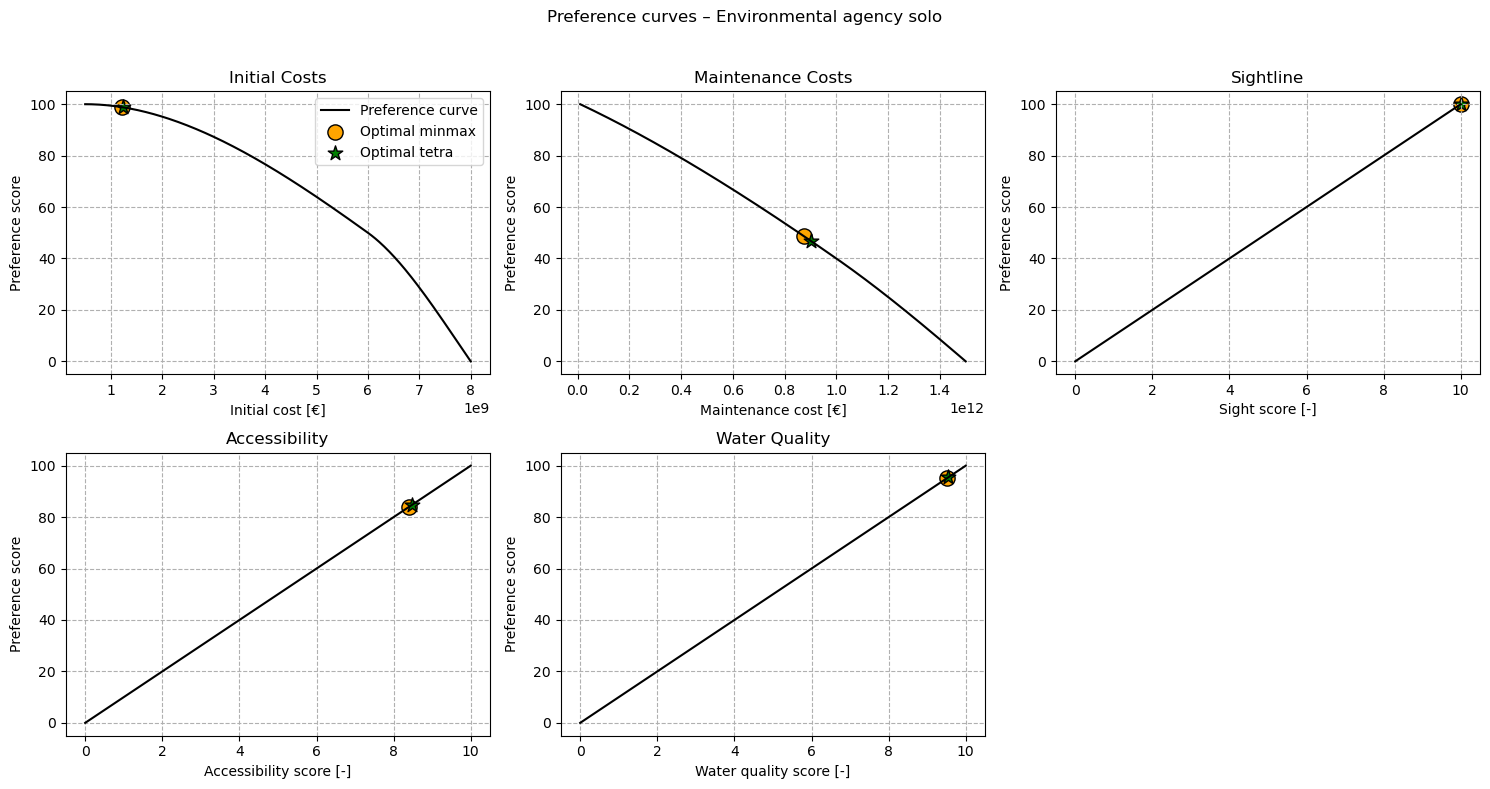

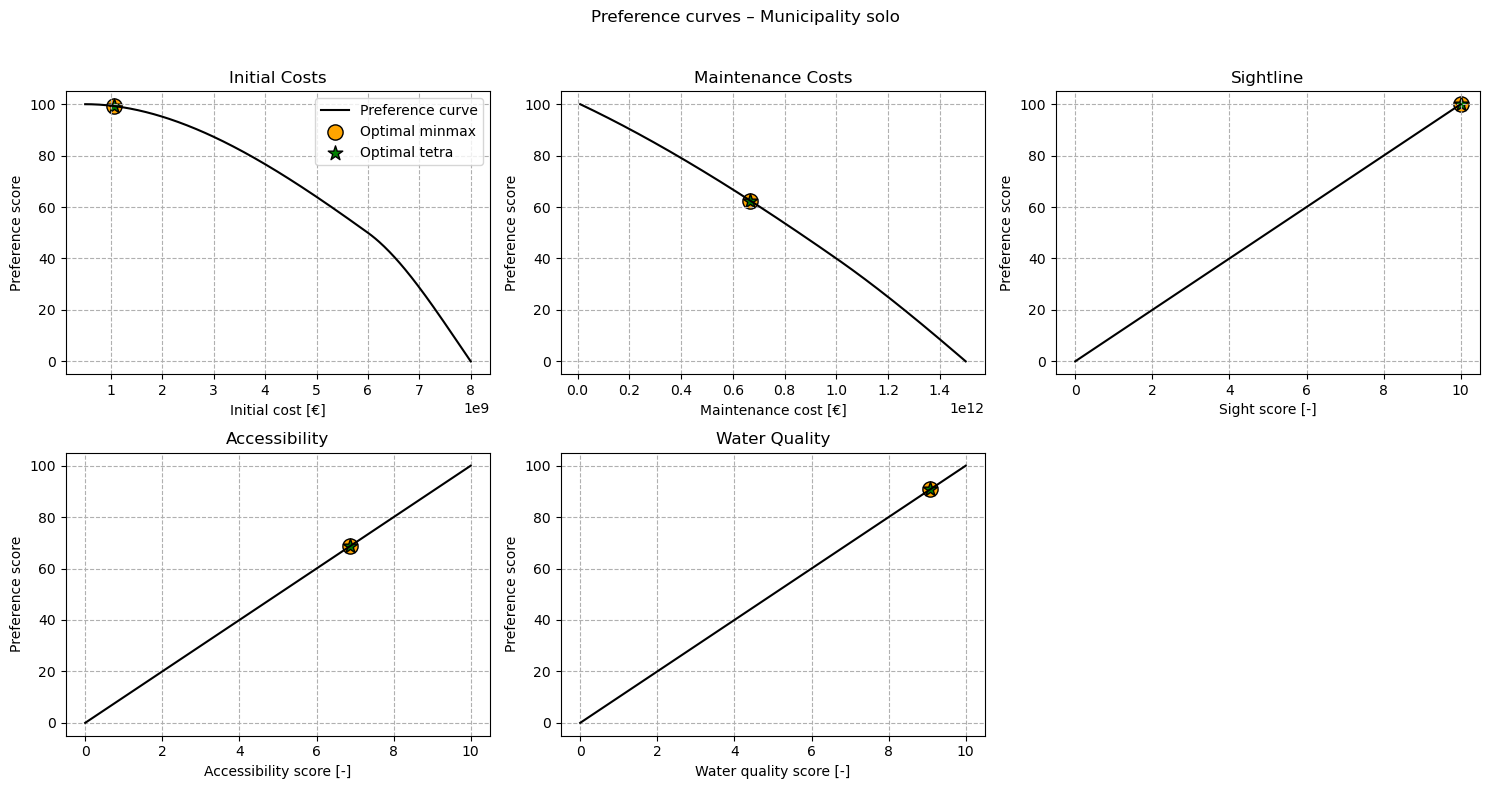

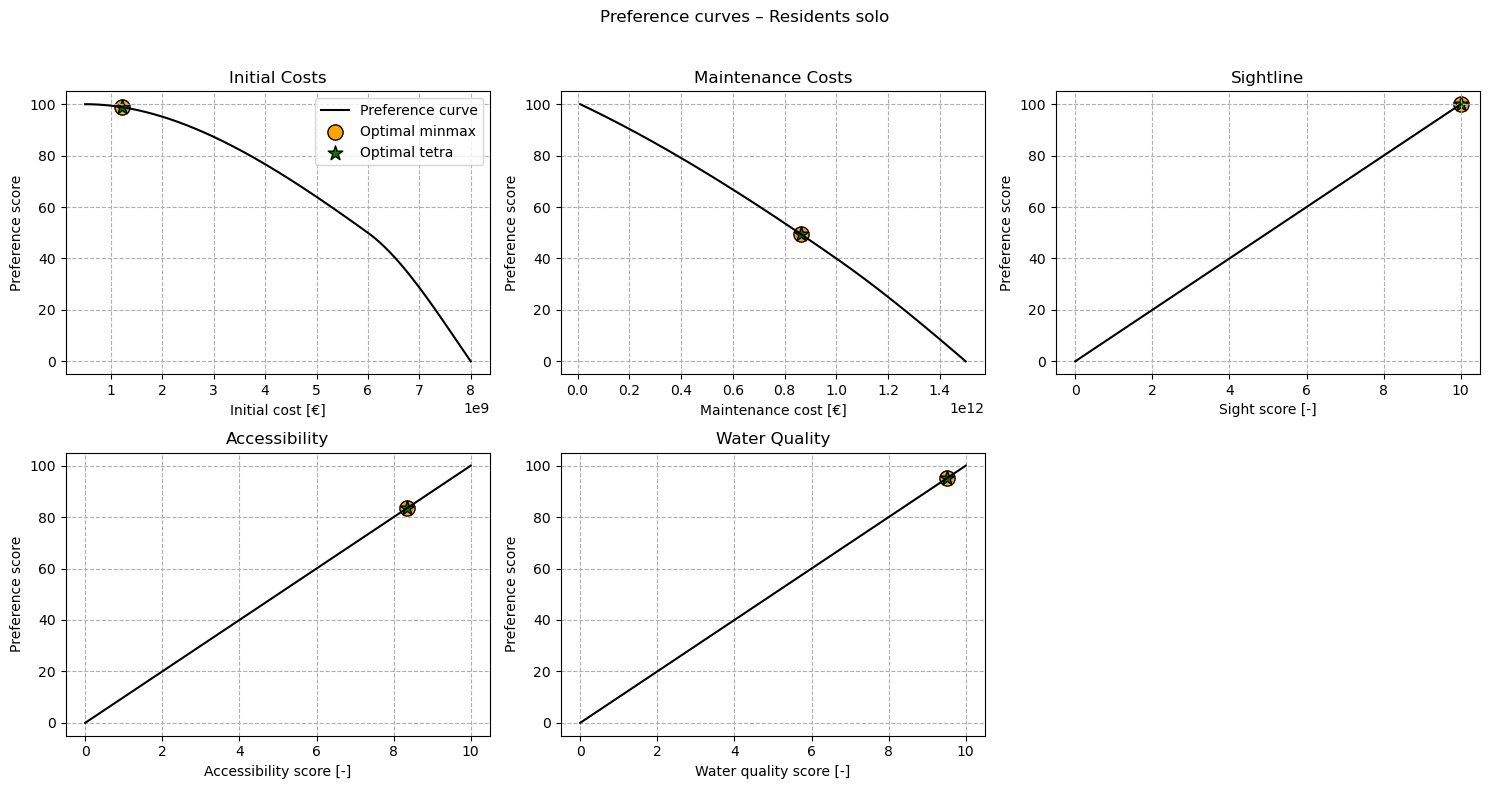

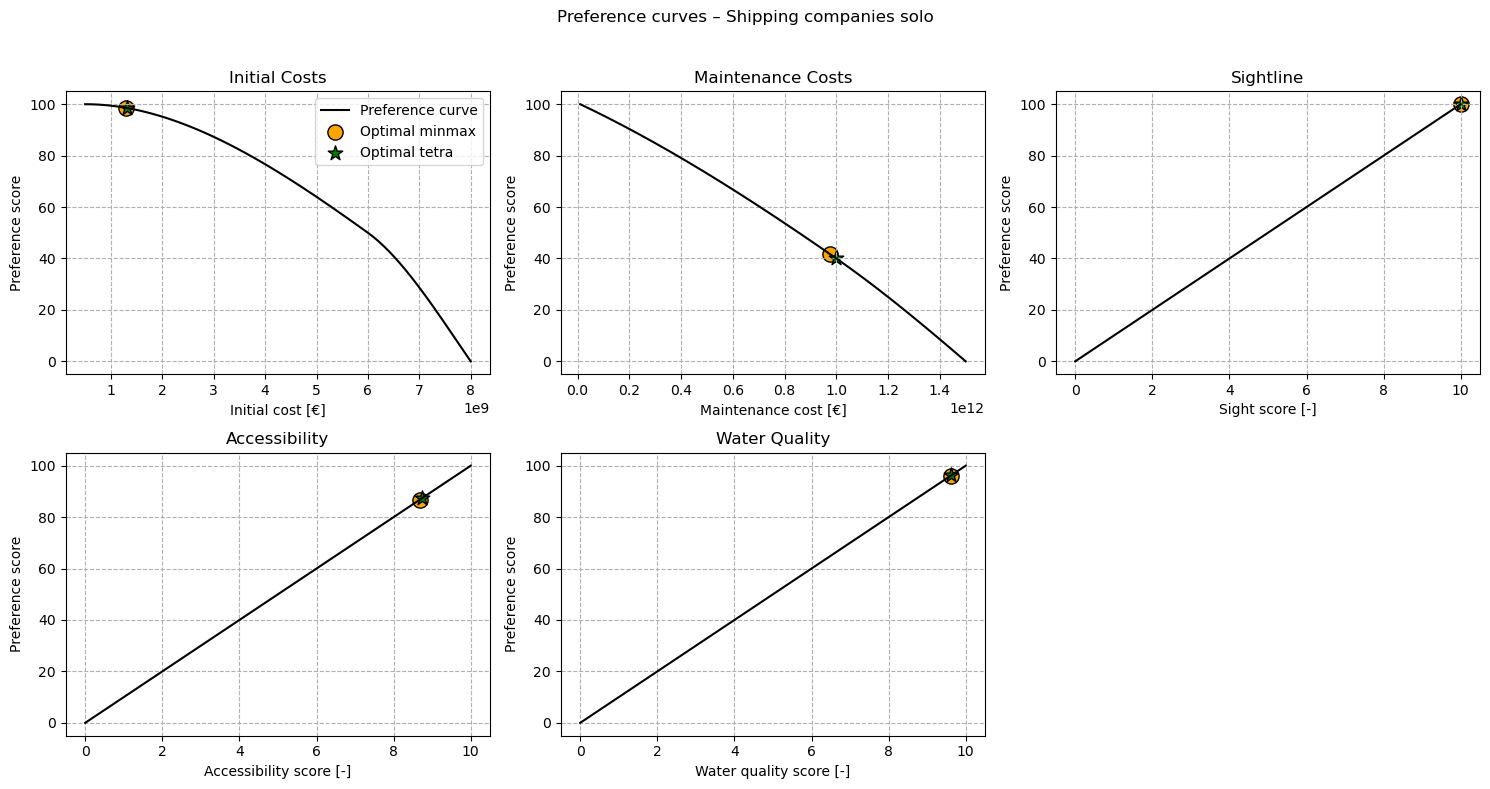

In [7]:
# Preference curves with GA solutions overlaid
if not history:
    raise RuntimeError('Run the GA cell first to populate history.')

objectives = [
    {
        'key': 'initial_cost',
        'title': 'Initial Costs',
        'knots_x': initial_cost_knots,
        'knots_y': initial_cost_pref,
        'compute': compute_initial_cost,
        'xlabel': 'Initial cost [€]'
    },
    {
        'key': 'maintenance_cost',
        'title': 'Maintenance Costs',
        'knots_x': maintenance_cost_knots,
        'knots_y': maintenance_cost_pref,
        'compute': compute_maintenance_cost,
        'xlabel': 'Maintenance cost [€]'
    },
    {
        'key': 'sight',
        'title': 'Sightline',
        'knots_x': sight_knots,
        'knots_y': sight_pref,
        'compute': compute_sight,
        'xlabel': 'Sight score [-]'
    },
    {
        'key': 'accessibility',
        'title': 'Accessibility',
        'knots_x': access_knots,
        'knots_y': access_pref,
        'compute': compute_accessibility,
        'xlabel': 'Accessibility score [-]'
    },
    {
        'key': 'water_quality',
        'title': 'Water Quality',
        'knots_x': water_knots,
        'knots_y': water_pref,
        'compute': compute_water_quality,
        'xlabel': 'Water quality score [-]'
    },
]

scenario_labels = sorted({record['scenario'] for record in history})

for scenario_label in scenario_labels:
    scenario_records = [record for record in history if record['scenario'] == scenario_label]
    if not scenario_records:
        continue

    n_cols = 3
    n_rows = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
    axes = axes.flatten()

    for idx_obj, obj in enumerate(objectives):
        ax = axes[idx_obj]
        knots_x = np.array(obj['knots_x'], dtype=float)
        knots_y = np.array(obj['knots_y'], dtype=float)

        # gather GA results for this objective
        samples = [knots_x.min(), knots_x.max()]
        for record in scenario_records:
            x1_opt, x2_opt, x3_opt = record['design']
            samples.append(obj['compute'](x1_opt, x2_opt, x3_opt))

        x_min = min(samples)
        x_max = max(samples)
        if np.isclose(x_min, x_max):
            x_max = x_min + 1.0

        x_range = np.linspace(x_min, x_max, 300)

        # Clip into knot domain to avoid extrapolation beyond preference definition
        x_range_clipped = np.clip(x_range, knots_x.min(), knots_x.max())
        pref_curve = pchip_interpolate(knots_x, knots_y, x_range_clipped)

        ax.plot(x_range, pref_curve, color='black', label='Preference curve')

        for i, record in enumerate(scenario_records):
            x1_opt, x2_opt, x3_opt = record['design']
            metric_value = obj['compute'](x1_opt, x2_opt, x3_opt)
            pref_value = record['preferences'][obj['key']]
            ax.scatter(metric_value, pref_value, color=colours[i % len(colours)],
                       marker=markers[i % len(markers)], s=120, edgecolor='black',
                       label=f"Optimal {record['paradigm']}")

        ax.set_title(obj['title'])
        ax.set_xlabel(obj['xlabel'])
        ax.set_ylabel('Preference score')
        ax.set_ylim(-5, 105)
        ax.grid(linestyle='--')

        if idx_obj == 0:
            ax.legend()

    # Hide the unused subplot if objectives < rows*cols
    for j in range(len(objectives), len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"Preference curves – {scenario_label}")
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
